In [1]:
# Import the necessary libraries
from core.glacier import GlacierDynamicsCheckpointed
import torch
from core.inversion import inversion_extent,inversion_thicknes
from visualization.plots import  visualize_velocities,plot_loss_components
import matplotlib.pyplot as plt
from core.utils import metrics_to_str,iterations_to_jsonl
from core.cnn_model import CNN
from data.loader import load_geology,load_daily_data
import pandas as pd
import numpy as np
import netCDF4
from config.read_config import parse_arguments  


%matplotlib inline

You are working on cuda device
Using device: cuda:1


In [2]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)
args = parse_arguments([])  # use defaults


cuda:1


In [3]:

config = {
"nb_layers": 8,               # Number of convolutional layers
"nb_out_filter": 64,           # Number of output filters for Conv2D
"conv_ker_size": 5,            # Convolution kernel size
"activation": "lrelu",          # Activation function: "relu" or "lrelu"
"dropout_rate": 0.1,           # Dropout rate
}
nb_inputs = 3  # thk, slopsurfx, slopsurfy
nb_outputs = 2  # ubar, vbar
state = torch.load('data/emulator_model.pth', map_location=device, weights_only=False)
model = CNN(nb_inputs, nb_outputs, config).to(device)
model.load_state_dict(state, strict=True)
model.eval()

CNN(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.1, inplace=False)
    (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0.1, inplace=False)
    (6): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Dropout(p=0.1, inplace=False)
    (9): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Dropout(p=0.1, inplace=False)
    (12): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (13): LeakyReLU(negative_slope=0.01)
    (14): Dropout(p=0.1, inplace=False)
    (15): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (16): LeakyReLU(negative_slope=0.01)
    (17): Dropout(p=0.1, inplace=False)
    (18): Conv2d(64, 64, kernel_size=(5, 5), stride=(

In [4]:
data, years = load_daily_data("temp_prec.dat")         # overwrite behavior

In [5]:
Z_topo,H_init, icemask = load_geology("data/geology.nc")

In [6]:
# Z_topo=Z_topo_[100:,:]
# H_init=H_init_[100:,:]
# icemask=icemask_[100:,:]


In [7]:
dx=100
dy=100
args.ttot=torch.tensor(2020.0)
args.t_start=torch.tensor(1790.0)
rho, g, fd=1,1,1
precip_tensor=1.85
T_m_lowest=7.5
T_s=10.0
melt_factor=2.7/12
# h_init=torch.zeros(Z_topo.shape, device=device)

In [8]:
# torch.save(H_sim,'Obs_cosine2.pt')

## Inversion

In [9]:

nc = netCDF4.Dataset('./data/geology.nc')
topo = torch.tensor(nc.variables['topg'][:], device=device)
obs_1880= torch.tensor(nc.variables['surf_1880'][:], device=device) -topo
obs_26= torch.tensor(nc.variables['surf_1926'][:], device=device) -topo
obs_57= torch.tensor(nc.variables['surf_1957'][:], device=device) -topo
obs_80= torch.tensor(nc.variables['surf_1980'][:], device=device) -topo
obs_99= torch.tensor(nc.variables['surf_1999'][:], device=device) -topo
obs_09= torch.tensor(nc.variables['surf_2009'][:], device=device) -topo
obs_17= torch.tensor(nc.variables['surf_2017'][:], device=device) -topo

nc.close()

In [10]:
glacier_model = GlacierDynamicsCheckpointed(
        Z_topo,H_init, ice_mask=icemask,device=device,args=args,model=model,visualize=True
    )

In [11]:
smb_precomputed = torch.load('data/smb_final.pt', map_location=device)

/tmp/ipykernel_2083892/3889865513.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  smb_precomputed = torch.load('data/smb_final.pt', map_location=device)


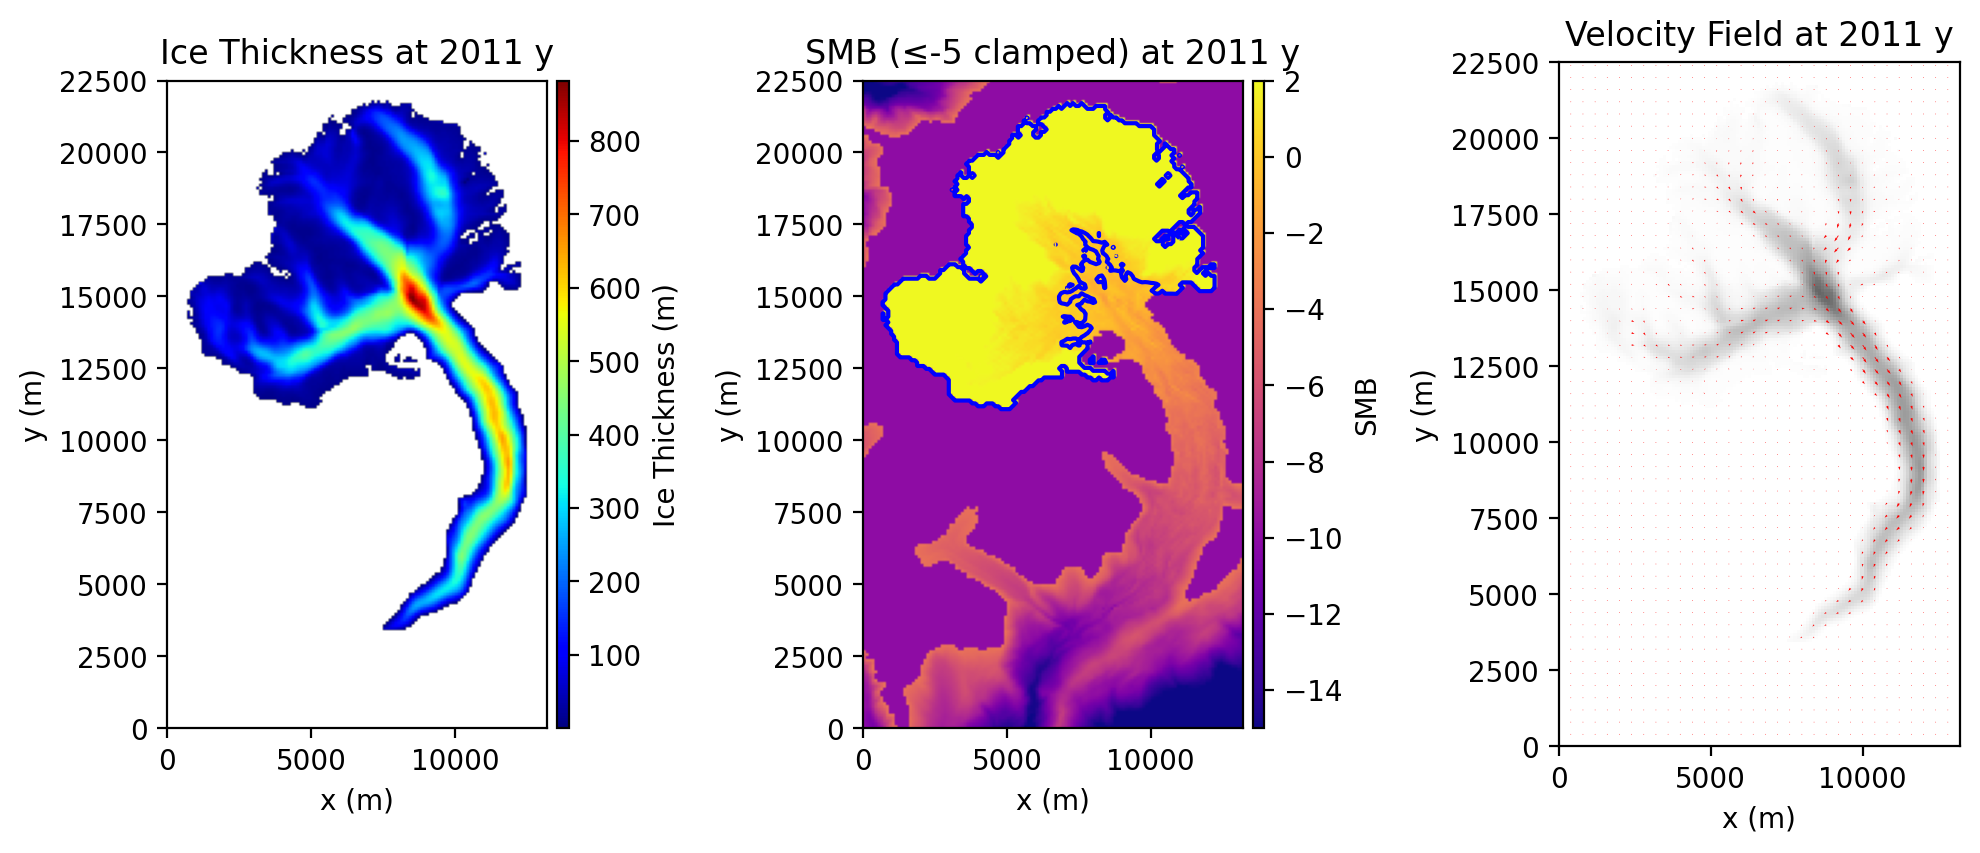

In [14]:
# Use it in the glacier model
H1880, H26, H57, H80, H99, H09, H17 = glacier_model(
    precip_tensor=None,
    T_m_lowest=None,
    T_s=None,
    P_daily=None,
    T_daily=None,
    melt_factor=None,
    smb_method='field',
    smb_field=smb_precomputed
)

In [20]:
H1880, H26, H57, H80, H99, H09, H17

(tensor([[-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
         [-0.0000, -0.0679, -0.1393,  ..., -0.2367, -0.1167, -0.0000],
         [-0.0000, -0.1369, -0.2784,  ..., -0.4737, -0.2348, -0.0000],
         ...,
         [-0.0000, -0.2164, -0.4374,  ..., -0.2572, -0.1286, -0.0000],
         [-0.0000, -0.1020, -0.2039,  ..., -0.1286, -0.0643, -0.0000],
         [-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000]],
        device='cuda:1'),
 tensor([[-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
         [-0.0000, -0.0676, -0.1388,  ..., -0.2359, -0.1163, -0.0000],
         [-0.0000, -0.1365, -0.2775,  ..., -0.4721, -0.2340, -0.0000],
         ...,
         [-0.0000, -0.2157, -0.4359,  ..., -0.2563, -0.1282, -0.0000],
         [-0.0000, -0.1016, -0.2032,  ..., -0.1282, -0.0641, -0.0000],
         [-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000]],
        device='cuda:1'),
 tensor([[-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.00

In [4]:
def plot_temp(T_m_lowest, iter,mf):
    time_axis = torch.linspace(time, ttot, steps=T_m_lowest.numel())
    fig, ax = plt.subplots()
    ax.plot(time_axis.numpy(), T_m_lowest.detach().cpu().numpy()-13.762, label='Reconstructed temperature')
    ax.plot([1880], [-4.5], marker='*', markersize=14, color='red', label='Observations')
    ax.plot([1926], [-4.2], marker='*', markersize=14, color='red')
    ax.plot([1957], [-4.0], marker='*', markersize=14, color='red')
    ax.plot([1999], [-3.0], marker='*', markersize=14, color='red')


    ax.set(title="Temperature Series Comparison", xlabel="Time [years]", ylabel="Temperature (°C)")
    ax.grid(True)
    ax.legend()
    fig.tight_layout()
    fig.savefig(f"visualization/FIGURES/{mf}temperatures_comparison{iter}.png", dpi=150, bbox_inches="tight")
    plt.close(fig)   # <-- critical


In [ ]:
# T_m_lowest_15=torch.load("thick_temp_for_mf0.125.pt")
# T_m_lowest_27=torch.load("thick_temp_for_mf0.225.pt")




In [ ]:
# plot_temp(T_m_lowest_15, 15, time_axis)
# plot_temp(T_m_lowest_27, 27, time_axis)

In [ ]:
# obs_1880,obs_26,obs_57,obs_80,obs_99 = glacier_model(precip_tensor, series, T_s,P_daily=None,T_daily=None,melt_factor=melt_factor)  # Use the checkpointed glacier model


In [ ]:
# Early stopping parameters
early_stop_patience = 10
early_stop_threshold = 1e-5
# Internal early stopping stateobs
best_loss = float('inf')
no_improve_count = 0

# _,obs, _ = load_geology("data/geology.nc")


# precip_tensor = torch.full(Z_topo.shape,1.3,requires_grad=False,device=device)
# precip_tensor = torch.tensor(precip_tensor,requires_grad=False,device=device)
# T_m_lowest = torch.linspace(7.0,8.0,len(series), requires_grad=True, device=device)
T_m_lowest = torch.full((int((ttot-time)/10 +1),1),7.0, requires_grad=True, device=device)
# T_m_lowest = torch.tensor(6.5, requires_grad=True, device=device)

# T_s = torch.tensor(10.0, requires_grad=False, device=device)

P_daily_=data[:,:,1]/1000
T_daily_=data[:,:,0]+13.762
# melt_factor= torch.tensor(1.5/365, requires_grad=True, device=device)


optimizer = torch.optim.Adam([T_m_lowest], lr=0.1)
loss_hist, Precip_history, data_hist = [], [], []
results = []
logs=[]

#define the weights of loss values:
w1980=1.0
w26=0.0
w57=0.0
w80=0.0
w99=0.0
w09=0.0
w17=0.0

for i in range(100):  # n_iterations
    optimizer.zero_grad()
    
    if i > 10:  w26=1.0
    if i > 20:  w57=1.0
    if i > 30:  w80=1.0; w99=1.0
    if i > 40:  w09=1.0; w17=1.0

    H_simulated, loss, metrics = inversion_thicknes(precip_tensor,T_m_lowest,T_s,
                                                        P_daily=P_daily_,T_daily=T_daily_,
                                                        melt_factor=melt_factor,
                                                        obs1880=obs_1880, obs26=obs_26 ,obs57=obs_57 ,obs80=obs_80 ,obs99=obs_99 ,obs09=obs_09, obs17= obs_17,
                                                        glacier_model=glacier_model,
                                                        reg_lambda=1,
                                                        w1980=w1980, w26=w26,w57=w57,w80=w80,w99=w99,w09=w09,w17=w17)
    
    loss.backward()
    optimizer.step()
    loss_hist.append(loss.item())
    # Precip_history.append(T_m_lowest.item())
    print(f"Iter {i+1}: loss={loss:.5f}")
    logs.append(f"Iter {i+1}: loss={loss.item():.5f}, metrics = {metrics_to_str(metrics)}")
    if i%5==0:
        # plot temperature and evolution
        plot_temp(T_m_lowest,i,melt_factor)
        plot_sim_with_obs_extent(sim=H_simulated[5], obs=obs_17,year=2017, thresh=1.0, iter= i)   
        # plot_sim_with_obs_extent(sim=H_simulated[4], obs=obs_99,year=1999, thresh=1.0, iter= i)   
        # plot_sim_with_obs_extent(sim=H_simulated[3], obs=obs_80,year=1980, thresh=1.0, iter= i)   
        # plot_sim_with_obs_extent(sim=H_simulated[2], obs=obs_57,year=1957, thresh=1.0, iter= i)   
        # plot_sim_with_obs_extent(sim=H_simulated[1], obs=obs_26,year=1926, thresh=1.0, iter= i)  
        # plot_sim_with_obs_extent(sim=H_simulated[0], obs=obs_1880,year=1880, thresh=1.0, iter= i)  

    # # Early stopping check
    # if i>1:
    #     if best_loss - loss.item() > early_stop_threshold:
    #         best_loss = loss.item()
    #         no_improve_count = 0
    #     else:
    #         no_improve_count += 1
    #         print(f"No significant improvement for {no_improve_count} iteration(s).")
    #     if no_improve_count >= early_stop_patience:
    #         print(f"1 Early stopping triggered at iteration {i + 1}.")
    #         break
    #     if loss.item() <= 0.001:
    #         print(f"2 Early stopping triggered at iteration {i + 1}.")
    #         break

    
#     results.append(f"Iter {i+1}: loss={loss:.3f}, precip={precip_tensor.mean().item():.3f}, T={T_m_lowest.mean().item():.3f}")
# # plot_gradient_evolution(grads, f"grad_{tag}.png")
# plot_loss_components(loss_hist,data_hist, f"loss_.png")
# torch.save(precip_tensor,f'Recon_Precip.pt')
# torch.save(H_simulated,f'Recon_Glac.pt')
      
iterations_to_jsonl(logs, "training_metrics.jsonl")


In [ ]:
plot_loss_components(loss_hist,data_hist, f"loss_.png")
args.outdir='./'
iterations_to_jsonl(logs,args)


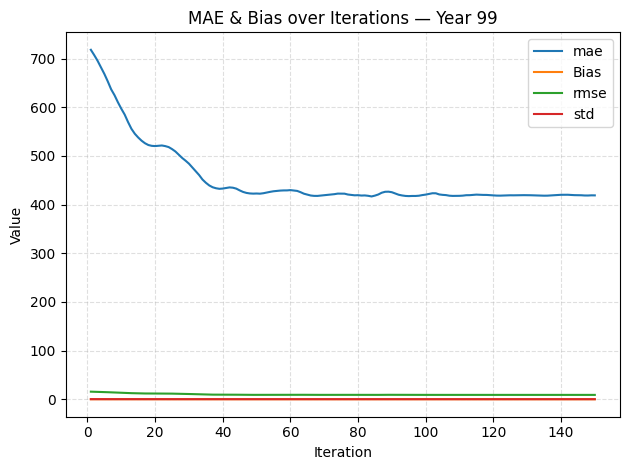

In [10]:
#!/usr/bin/env python3
import json

jsonl_path = "./results/ext_l2_1926_sequential+sigmoid/training_metrics.jsonl"
year_key ="99"

iters, mae, biases, rmse, std = [], [], [], [], []
with open(jsonl_path, "r", encoding="utf-8") as f:
    for line in f:
        if not line.strip():
            continue
        rec = json.loads(line)
        m = rec.get("metrics", {})
        iters.append(rec["iter"])
        mae.append(float(m[year_key]["mae"]))
        biases.append(float(m[year_key]["bias"]))
        rmse.append(float(m[year_key]["rmse"]))
        std.append(float(m[year_key]["std"]))


# sort by iteration
order = sorted(range(len(iters)), key=lambda i: iters[i])
iters  = [iters[i]  for i in order]
mae   = [mae[i]   for i in order]
biases = [biases[i] for i in order]
rmse = [rmse[i] for i in order]
std = [std[i] for i in order]


if not iters:
    raise SystemExit(f"No data found for year '{year_key}'.")

plt.figure()
plt.plot(iters, mae, label="mae")
plt.plot(iters, biases, label="Bias")
plt.plot(iters, rmse, label="rmse")
plt.plot(iters, std, label="std")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.title(f"MAE & Bias over Iterations — Year {year_key}")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


In [43]:
def _mask(x: torch.Tensor, thresh: float) -> torch.Tensor:
    """
    mask observation/simulations using a sigmoid function
    """
    scale =0.1 # Steeper sigmoid using a scaling factor
    return torch.sigmoid(scale * (x - 1)).to(x.dtype)




In [44]:
O1880 = _mask(obs_1880, 1.0)

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

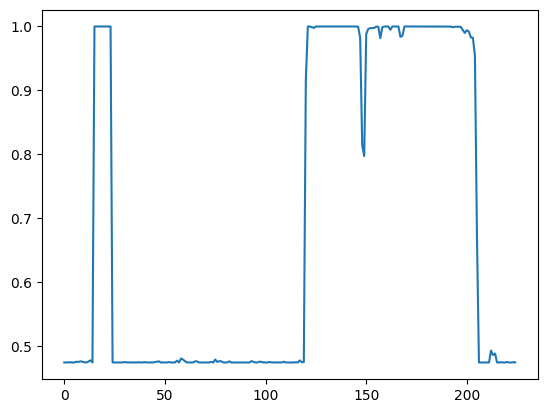

In [45]:
plt.plot(O1880[:,60].cpu().numpy())
plt.colorbar()

In [ ]:
time_axis = torch.linspace(time, ttot, steps=T_m_lowest.numel())
fig, ax = plt.subplots()
ax.plot(time_axis.numpy(), T_m_lowest.detach().cpu().numpy()-13.762, label='Reconstructed temperature')
ax.plot([1880], [-4.5], marker='*', markersize=14, color='red', label='Observations')
ax.plot([1926], [-4.2], marker='*', markersize=14, color='red')
ax.plot([1957], [-4.0], marker='*', markersize=14, color='red')
ax.plot([1999], [-3.0], marker='*', markersize=14, color='red')
ax.set(title="Temperature Series Comparison", xlabel="Time [years]", ylabel="Temperature (°C)")
ax.grid(True)
ax.legend()
fig.tight_layout()
fig.show()

In [ ]:
plot_loss_components(loss_hist,data_hist, f"loss_.png")


In [ ]:
plot_loss_components(loss_hist,data_hist, f"loss_.png")

In [ ]:
def plot_temp_multi(mf_files, melt_factors, iter, time_axis, baseline=13.762,
                    outpath=f"visualization/movie/temp_comparison"):
    """
    Plot reconstructed temperature series for multiple melt factors on one figure.

    Parameters
    ----------
    mf_files : list[str]
        Paths to .pt files containing T_m_lowest tensors (one per melt factor).
    melt_factors : list[float|str]
        Labels for melt factors, same order/length as mf_files.
    iter : int
        Iteration number used in the output filename.
    time_axis : torch.Tensor | np.ndarray
        Time values aligned with T_m_lowest series.
    baseline : float
        Value subtracted from each series (your 13.762).
    outpath : str
        Prefix path for the saved PNG (filename will append {iter}.png).
    """
    # Ensure time axis is numpy
    if hasattr(time_axis, "detach"):
        t = time_axis.detach().cpu().numpy()
    else:
        t = np.asarray(time_axis)

    fig, ax = plt.subplots()

    # Plot each reconstruction series
    for fpath, mf in zip(mf_files, melt_factors):
        T = torch.load(fpath)  # expects a 1D tensor
        if hasattr(T, "detach"):
            T = T.detach().cpu().numpy()
        else:
            T = np.asarray(T)

        ax.plot(t, T - baseline, label=f"Reconstructed (mf={mf})")

    # Reference points (stars)
    ref_years = [1880, 1926, 1957, 1999]
    ref_temps = [-4.5, -4.2, -4.0, -3.0]
    ax.plot([ref_years[0]], [ref_temps[0]], marker='*', markersize=14, color='red', label='References')
    for x, y in zip(ref_years[1:], ref_temps[1:]):
        ax.plot([x], [y], marker='*', markersize=14, color='red')

    ax.set(title="Temperature Series Comparison",
           xlabel="Time [years]",
           ylabel="Temperature (°C)")
    ax.grid(True)
    ax.legend()
    fig.tight_layout()
    fig.savefig(f"{outpath}{iter}.png", dpi=150, bbox_inches="tight")
    plt.close(fig)  # keep loops tidy if called many times

time_axis = torch.linspace(time, ttot, steps=series.numel()+1)

# Example usage:
mf_files = ["extent_temp_for_mf1.0.pt", "extent_temp_for_mf1.5.pt", "extent_temp_for_mf2.7.pt"]
melt_factors = [1.0, 1.5, 2.7]
plot_temp_multi(mf_files, melt_factors, iter=0, time_axis=time_axis)

In [ ]:
plot_temp(T_m_lowest,i,time_axis)


In [ ]:
# plot_temp(T_m_lowest)
# torch.save(T_m_lowest,f'Recon_temp.pt')

In [ ]:
# T_m_lowest=torch.load('Recon_temp')

In [ ]:
H1880, H26,H57,H80,H99, H09, H17 = glacier_model(precip_tensor, T_m_lowest, T_s,P_daily=P_daily_,T_daily=T_daily_,melt_factor=melt_factor)  # Use the checkpointed glacier model


In [ ]:
H17

In [ ]:
plot_sim_with_obs_extent(sim=H99, obs=obs_99,year=1999, thresh=1.0)   
plot_sim_with_obs_extent(sim=H80, obs=obs_80,year=1980, thresh=1.0)   
plot_sim_with_obs_extent(sim=H57, obs=obs_57,year=1957, thresh=1.0)   
plot_sim_with_obs_extent(sim=H26, obs=obs_26,year=1926, thresh=1.0)  
plot_sim_with_obs_extent(sim=H1880, obs=obs_1880,year=1880, thresh=1.0)  

## Make a figure that justifies why we should invert for temperature and not precipitation


In [ ]:
# Load the file (the user mentioned skiprows=2 and known column order)
file_path = "temp_prec.dat"

# Load with numpy
arr = np.loadtxt(file_path, dtype=np.float32, skiprows=2)

# Create dataframe
df = pd.DataFrame(arr, columns=["year", "jd", "hour", "temp", "prec"])

In [ ]:
# Ensure types are clean
df["year"] = df["year"].astype(int)
df["jd"]   = df["jd"].astype(int)

# Sort just to be tidy
df = df.sort_values(["year", "jd"], kind="mergesort")

# Get the list of years in order and a mapping to indices
years = np.sort(df["year"].unique())
year_to_idx = {y: i for i, y in enumerate(years)}

# Initialize output: (n_years, 366 days, 2 vars [temp, prec])
out = np.zeros((len(years), 366, 2), dtype=np.float32)

# Clip JD to 1..366 just in case (optional safety)
jd = df["jd"].to_numpy()
jd = np.clip(jd, 1, 366)

# Vectorized placement:
yidx = df["year"].map(year_to_idx).to_numpy()
didx = jd - 1  # 0-based day index

out[yidx, didx, 0] = df["temp"].to_numpy(dtype=np.float32)  # temperature
out[yidx, didx, 1] = df["prec"].to_numpy(dtype=np.float32)  # precipitation

print(out.shape)   # should be (len(years), 366, 2)

In [ ]:
plt.figure()
# print(out[-1,:,1])
plt.plot(out[1,:,0]+18.0)
plt.plot(out[1,:,0]+11.0)
plt.plot(out[1,:,0]+4.0)
plt.plot(out[1,:,0])
plt.axhline(0, linestyle='--', linewidth=1)



In [ ]:
print((out[1,:,1]).sum())
print((out[2,:,1]).sum())
print((out[3,:,1]).sum())
print((out[4,:,1]).sum())


In [ ]:
# thr=0.2


# print(1.5/365*torch.clamp((out[1,:,0]+18.0) - thr, min=0).sum())
# print(2/365*torch.clamp((out[1,:,0]+11.0) - thr, min=0).sum())
# print(2/365*torch.clamp((out[1,:,0]+4.0) - thr, min=0).sum())
# print(2/365*torch.clamp((out[1,:,0]) - thr, min=0).sum())


In [ ]:
print(df.head())

In [ ]:
# For rolling averages, choose window (e.g., 30 samples)
window = 30
df["temp_roll"] = df["temp"].rolling(window, center=True).mean()
df["prec_roll"] = df["prec"].rolling(window, center=True).mean()

# Create a time index (approximate: year + jd/365 + hour/8760)
time_index = df["year"] + (df["jd"] - 1)/365.0 + df["hour"]/8760.0

# Temperature figure
plt.figure(figsize=(10,4))
color = "C0"
plt.plot(time_index, df["temp"], color=color, alpha=0.6, label="Temperature")
plt.plot(time_index, df["temp_roll"], color=color, linewidth=2.5, label="Rolling Avg")
plt.xlabel("Year")
plt.ylabel("Temperature")
plt.legend()
plt.title("Temperature Evolution")
plt.show()

# Precipitation figure
plt.figure(figsize=(10,4))
color = "C1"
plt.plot(time_index, df["prec"], color=color, alpha=0.6, label="Precipitation")
plt.plot(time_index, df["prec_roll"], color=color, linewidth=2.5, label="Rolling Avg")
plt.xlabel("Year")
plt.ylabel("Precipitation")
plt.legend()
plt.title("Precipitation Evolution")
plt.show()
